In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%matplotlib inline

In [2]:
from src.ptp.models.gan_3d.gan3d import Generator
from src.ptp.models.gan_3d.discriminator import Discriminator
from src.ptp.models.gan_3d.gan3d import GAN3D
from src.ptp.models.utils import num_trainable_params
from src.ptp.evaluation.visualization import visualize_slices, visualize_volumes, plot_slice
from src.ptp.models.losses import tce_loss
from pathlib import Path
from lightning.pytorch.loggers import TensorBoardLogger

import matplotlib.pyplot as plt
import nibabel as nib  
import numpy as np

from monai.data import MetaTensor
import pytorch_lightning as pl
import torch
from torch import nn
import os

In [23]:
DATA_DIR = Path('../data/generated_part1_nii_gz')
TARGET_DATA_DIR = DATA_DIR
INPUT_DIR = Path('../data')
MODELS_DIR = INPUT_DIR / 'models'
TRAINING_DIR = INPUT_DIR / 'training'
os.makedirs(TRAINING_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

In [24]:
percentile = 5
n_critic = 1  # for training more k steps about Discriminator

In [25]:
gan = GAN3D(target_data_dir=TARGET_DATA_DIR, percentile=percentile, n_critic=n_critic, recon_loss=tce_loss)

In [26]:
print(f"Generator size is {num_trainable_params(gan.G)}")
print(f"Discriminator size is {num_trainable_params(gan.D)}")

Generator size is 587011
Discriminator size is 410096


In [8]:
gan.prepare_data()
train_loader = gan.train_dataloader()

Target stats: (0.05286923511420483, -1.0, 1.0)
Image stats: (0.2101914140576614, -0.9999516606330872, 1.0)


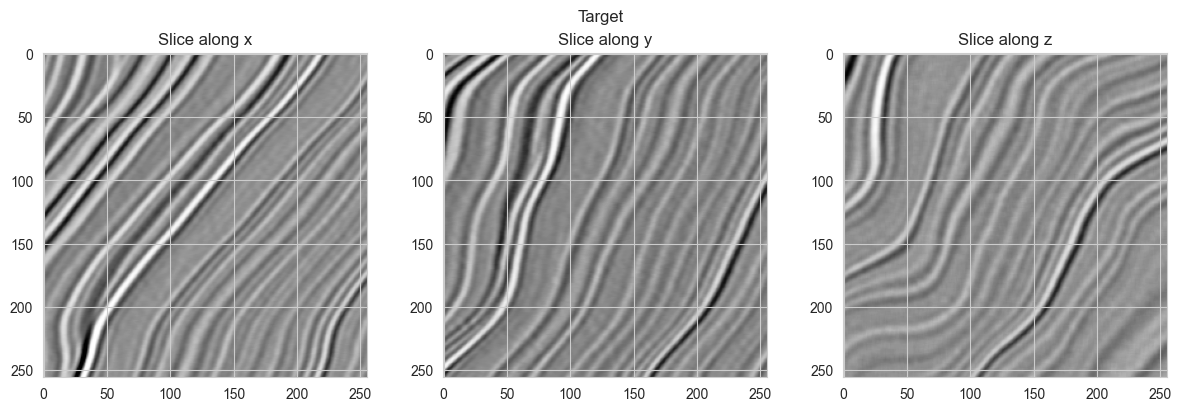

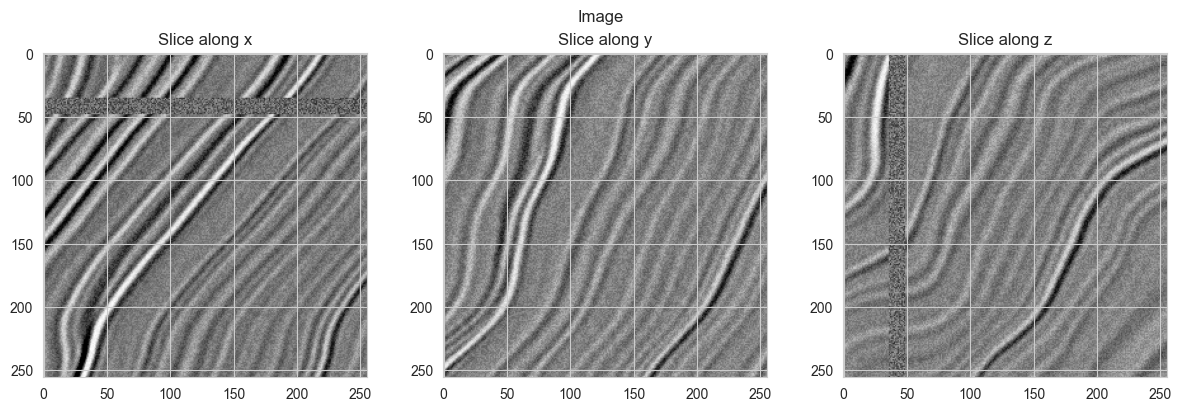

In [9]:
x, y, z = 50, 150, 200
for i, batch in enumerate(train_loader):
    target = nib.Nifti1Image(batch['target'].numpy()[0, 0], np.eye(4))
    image = nib.Nifti1Image(batch['image'].numpy()[0, 0], np.eye(4))
    plot_slice(target, x, y, z, f'Target')
    plot_slice(image, x, y, z, f'Image')
    
    print(f'Target stats: {np.mean(target.get_fdata()), np.min(target.get_fdata()), np.max(target.get_fdata())}')
    print(f'Image stats: {np.mean(image.get_fdata()), np.min(image.get_fdata()), np.max(image.get_fdata())}')

In [27]:
model_name = '3DGAN-tce-loss'

In [28]:
logger = TensorBoardLogger("tb_logs", name=model_name)

In [29]:
max_epochs = 20

checkpoint_dir = TRAINING_DIR / model_name

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

trainer = pl.Trainer(
    max_epochs=max_epochs,
    default_root_dir=checkpoint_dir,
    callbacks=[checkpoint_callback],
    fast_dev_run=False,
    logger=logger
)

trainer.fit(gan)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\julia\anaconda3\envs\ptp2\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\Users\julia\PycharmProjects\SOLVRO-PTP2\data\training\3DGAN-tce-loss exists and is not empty.

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | G    | Generator     | 587 K  | train
1 | D    | Discriminator | 410 K  | train
-----------------------------------------------
997 K     Trainable params
0         Non-trainable params
997 K     Total params
3.988     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1/1 [01:15<00:00,  0.01it/s, v_num=1, g_loss_step=1.470, d_loss_step=1.090, n_step_step=0.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:51<00:00,  0.02it/s, v_num=1, g_loss_step=1.360, d_loss_step=0.695, n_step_step=1.000, val_g_loss=0.294, val_d_loss=0.758, val_loss=1.050, g_loss_epoch=1.470, d_loss_epoch=1.090, n_step_epoch=0.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:57<00:00,  0.02it/s, v_num=1, g_loss_step=0.914, d_loss_step=0.804, n_step_step=2.000, val_g_loss=0.603, val_d_loss=0.594, val_loss=1.200, g_loss_epoch=1.360, d_loss_epoch=0.695, n_step_epoch=1.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:50<00:00,  0.02it/s, v_num=1, g_loss_step=0.177, d_loss_step=0.442, n_step_step=3.000, val_g_loss=0.442, val_d_loss=0.723, val_loss=1.160, g_loss_epoch=0.914, d_loss_epoch=0.804, n_step_epoch=2.000]
Validation: |          | 0/? [00:00<?, ?it

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [01:22<00:00,  0.01it/s, v_num=1, g_loss_step=1.170, d_loss_step=0.828, n_step_step=19.00, val_g_loss=0.704, val_d_loss=1.060, val_loss=1.770, g_loss_epoch=1.170, d_loss_epoch=0.828, n_step_epoch=19.00]


In [32]:
%tensorboard --logdir tb_logs

Launching TensorBoard...

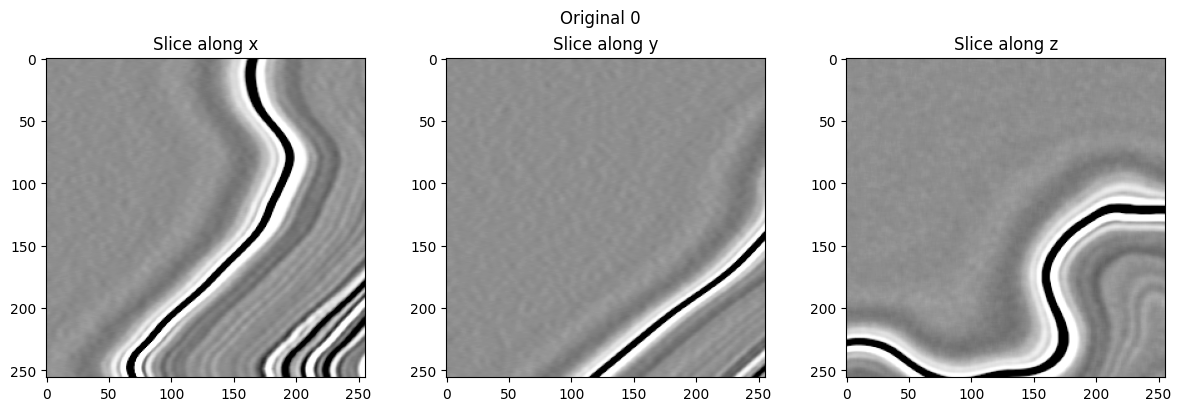

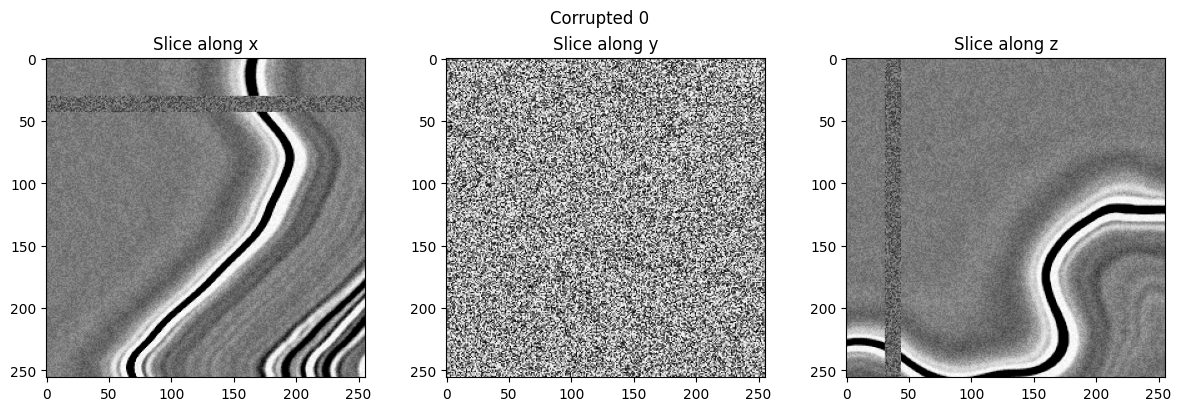

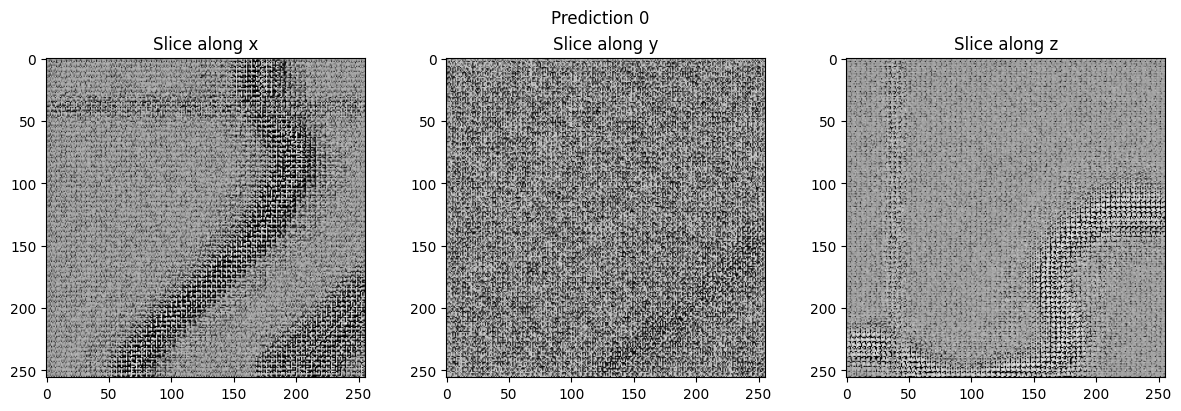

In [31]:
keys = ['target','image', 'prediction']
labels = ['Original','Corrupted', 'Prediction']

train_loader = gan.train_dataloader()

for i, batch in enumerate(train_loader):
    prediction = gan(batch['image'])
    batch['prediction'] = prediction
    visualize_volumes(batch, i, keys, labels, True)